# Chest X-ray Project

### Importing needed libraries

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"  # - only if using AMD card

import keras
import keras.applications as kapp
from keras.applications import *

from keras.preprocessing import image
from keras.models import Model
import numpy as np
import io

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

from keras.preprocessing import image
from keras.models import Model


from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import time
from sklearn.metrics import accuracy_score
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

Using plaidml.keras.backend backend.


### Images preparation

In [2]:
train_data_dir = r'C:\Users\Filip\Desktop\Python\Projekt_kodołamacz\chest_xray\chest_xray\train'
test_data_dir = r'C:\Users\Filip\Desktop\Python\Projekt_kodołamacz\chest_xray\chest_xray\test'


img_width, img_height = 200, 200
batch_size = 16


nb_train_samples = 1000 # adjustable, possible to increase depending on computing power
nb_validation_samples = 624


train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   brightness_range= [0.5,1.5],
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255) # test images without augmentation, only rescaling

train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(test_data_dir,target_size=(img_height, img_width), 
                                                        batch_size=batch_size,class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Example of image

1.0


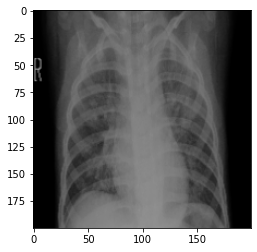

In [3]:
plt.imshow(train_generator[0][0][0])
print(train_generator[0][1][0]) #if 1 then pneumonia

1.0


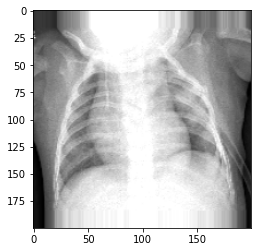

In [4]:
plt.imshow(train_generator[0][0][1])
print(train_generator[0][1][1]) #if 1 then pneumonia

1.0


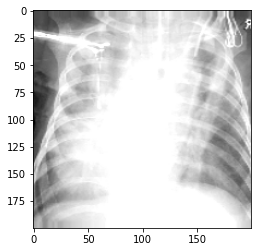

In [5]:
plt.imshow(train_generator[0][0][2])
print(train_generator[0][1][2]) #if 1 then pneumonia

### Model evaluation preparation

In [6]:
def evaluate_model(model, generator):
    score = model.evaluate_generator(generator=generator,              
                                     verbose=0)
    return(score[0], score[1])

In [7]:
# Preparing dashboard
wyniki = pd.DataFrame(columns = ['val_loss','val_acc'])

### Training models

In [8]:
h,w = 200, 200 # hight and width of input data for model

### ResNet50

In [9]:
# Model CNN - ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(h,w,3)) 

# Top layers
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# Combinig base model with additional CNN layers
new_model = Sequential()
new_model.add(base_model)
new_model.add(top_model)
new_model.layers[0].trainable = False

# Model compilation
new_model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Callbacks
my_callbacks = [
    EarlyStopping(patience=4, monitor='val_loss', min_delta=0.05, restore_best_weights=True),
    ModelCheckpoint(filepath='model_ResNet50.h5')
]



# CNN training
new_model.fit_generator(train_generator, 
                        steps_per_epoch=nb_train_samples, 
                        epochs=80, 
                        callbacks=my_callbacks, 
                        validation_data=validation_generator, 
                        validation_steps=nb_validation_samples)

INFO:plaidml:Opening device "opencl_amd_pitcairn.0"
C:\Users\Filip\.conda\envs\ML\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 146s 2us/step
Epoch 1/80


INFO:plaidml:Analyzing Ops: 1103 of 1334 operations complete


1000/1000 [==============================] - 664s 664ms/step - loss: 2.0488 - acc: 0.8682 - val_loss: 5.9784 - val_acc: 0.6250
Epoch 2/80
1000/1000 [==============================] - 640s 640ms/step - loss: 1.4471 - acc: 0.9074 - val_loss: 5.9784 - val_acc: 0.6250
Epoch 3/80
1000/1000 [==============================] - 635s 635ms/step - loss: 1.2504 - acc: 0.9204 - val_loss: 5.9784 - val_acc: 0.6250
Epoch 4/80
1000/1000 [==============================] - 638s 638ms/step - loss: 1.3722 - acc: 0.9128 - val_loss: 5.9784 - val_acc: 0.6250
Epoch 5/80
1000/1000 [==============================] - 635s 635ms/step - loss: 1.3864 - acc: 0.9121 - val_loss: 5.9784 - val_acc: 0.6250


In [11]:
# Adding results to dashboard
wyniki.loc['ResNet50'] = evaluate_model(new_model, validation_generator)
wyniki

,val_loss,val_acc
ResNet50,5.978394,0.625


In [12]:
# Saving results to txt file
with open('results.txt', 'a') as f:
    f.write(
        
        (wyniki.to_string(header = False, index = True) + "\n")
    )